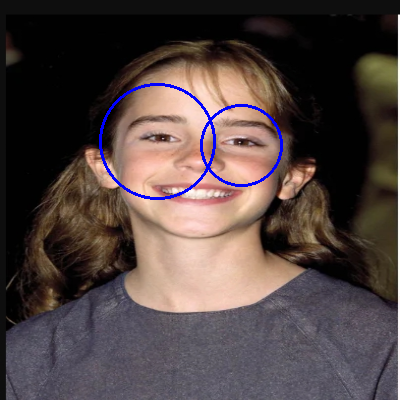

In [11]:
import pandas as pd
import cv2
import os
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from IPython.display import display

file_path = "kr1.xlsx"
df = pd.read_excel(file_path)

variant_index = 1
row = df.iloc[variant_index]

image_folder = "source_images"
output_folder = "results"
os.makedirs(output_folder, exist_ok=True)

image_path = os.path.join(image_folder, row["file name"])
output_path = os.path.join(output_folder, f"processed_{row['file name']}")

target_size = tuple(map(int, row["image size"].split("x")))
glasses_color = row["glasses color"]
line_width = int(row["line width"])

image = cv2.imread(image_path)

if image is None:
    print("Помилка: зображення не знайдено!")
else:
    image = cv2.resize(image, target_size)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")

    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(100, 100))

    if len(faces) > 0:
        x, y, w, h = faces[0]
        face_roi = gray[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(face_roi)

        if len(eyes) >= 2:
            eyes = sorted(eyes, key=lambda e: e[0])
            eye1, eye2 = eyes[:2]

            pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            draw = ImageDraw.Draw(pil_image)

            for (ex, ey, ew, eh) in (eye1, eye2):
                center = (x + ex + ew // 2, y + ey + eh // 2)
                radius = int(ew * 0.8)
                draw.ellipse(
                    [center[0] - radius, center[1] - radius, center[0] + radius, center[1] + radius],
                    outline=glasses_color, width=line_width
                )

            pil_image.save(output_path)
            display(pil_image)
        else:
            print("Очі не знайдено!")
    else:
        print("Обличчя не знайдено!")